# Mean-variance optimization

In [1]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def calc_cov(deviations: np.ndarray, cor: np.ndarray) -> np.ndarray:
    """
    This function calculates the covariance matrix based on a given correlation matrix and array of standard deviations.

    Args:
    - deviations (np.ndarray): 1D array of standard deviations for each variable.
    - cor (np.ndarray): 2D correlation matrix.

    Returns:
    - 2D covariance matrix calculated from the input arrays.
    """
    # Calculate the outer product of the standard deviations to get a matrix of variances
    variances = np.outer(deviations, deviations)
    
    # Calculate the covariance matrix by element-wise multiplication of the correlation matrix with the variance matrix
    return cor * variances

def portolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_variance(weights, cov_matrix):
    port_variance = np.dot(np.dot(weights, cov_matrix), weights.T)
    return port_variance

def sharpe_ratio(weights, returns, cov_matrix, rf_return):
    return (portolio_return(weights, returns) - rf_return) / \
        (portfolio_variance(weights, cov_matrix)**0.5)

def find_mve(returns, cov_matrix, rf_return):
    """
    This is a function to find the weights of a Mean-variance Efficient Portfolio (MVE) that maximizes the Sharpe Ratio.

    Parameters
    ----------
    - returns:   : an array of expected returns for each asset in the portfolio
    - cov_matrix : a covariance matrix for the assets in the portfolio
    - rf_return  : the risk-free return

    Returns
    -------
    The function returns a pandas Series object, containing:
    - w1..n: the optimal weights for each asset in the portfolio
    - Return: the expected return of the portfolio
    - Deviation: the expected standard deviation of the portfolio
    - Sharpe Ratio: the Sharpe Ratio of the portfolio
    """    
    # Constraints: weights must sum up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds on weights: each weight must be between 0 and 1
    bnds = [(0, 1) for i in range(0, len(cov_matrix))]

    # Initial guess of equal weights for each asset
    init_guess = [1/len(cov_matrix) for i in range(0, len(cov_matrix))]

    # Solve the optimization problem
    opt_results = minimize(
        lambda w: -sharpe_ratio(w, returns, cov_matrix, rf_return), 
        init_guess, 
        constraints=cons, 
        bounds=bnds)
    weights = np.round(opt_results.x, decimals=3)
    p_return = portolio_return(weights, returns)
    p_deviation = portfolio_variance(weights, cov_matrix)**0.5
    sr = sharpe_ratio(weights, returns, cov_matrix, rf_return)
    labels = np.append(['w' + str(i) for i in range(1, len(weights)+1)], 
        ['Return', 'Deviation', 'Sharpe Ratio'])
    return pd.Series(np.append(weights, [p_return, p_deviation, sr]), index=labels)

def find_gmv(returns, cov_matrix, rf_return):
    # Constraints: weights must sum up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds on weights: each weight must be between 0 and 1
    bnds = [(0, 1) for i in range(0, len(cov_matrix))]

    # Initial guess of equal weights for each asset
    init_guess = [1/len(cov_matrix) for i in range(0, len(cov_matrix))]

    # Solve the optimization problem
    opt_results = minimize(
        lambda w: portfolio_variance(w, cov_matrix), 
        init_guess, 
        constraints=cons, 
        # if you do not allow short selling, uncomment below code
        # bounds=bnds
        )
    weights = np.round(opt_results.x, decimals=3)
    p_return = portolio_return(weights, returns)
    p_deviation = portfolio_variance(weights, cov_matrix)**0.5
    sr = sharpe_ratio(weights, returns, cov_matrix, rf_return)
    labels = np.append(['w' + str(i) for i in range(1, len(weights)+1)], 
        ['Return', 'Deviation', 'Sharpe Ratio'])
    return pd.Series(np.append(weights, [p_return, p_deviation, sr]), index=labels)

## Mean-variance efficient portfolio (two assets)

Define two risky assets and return of risk-free asset:

In [2]:
assets_df = pd.DataFrame({
  'Return': [0.1355, 0.1497],
  'Deviation': [0.1535, 0.2298]
}, index=['US', 'Japan'])
asset_cor = pd.DataFrame({
  'US': [1, 0.2663],
  'Japan': [0.2663, 1],
}, index=['US',  'Japan'])
rf_return = 0.05
asset_cov = calc_cov(assets_df['Deviation'], asset_cor.to_numpy())
asset_cov

array([[0.02356225, 0.00939355],
       [0.00939355, 0.05280804]])

Find the mean-variance efficient portfolio

In [77]:
mve = find_mve(assets_df['Return'], asset_cov, rf_return)
mve

w1              0.698000
w2              0.302000
Return          0.139788
Deviation       0.142324
Sharpe Ratio    0.630872
dtype: float64

Construct capital allocation line

In [78]:
cal_df = pd.DataFrame({ 'w_mve': np.arange(0, 1.8, step=0.1) })
cal_df['w_rf'] = 1 - cal_df['w_mve']
cal_df['Return'] = np.dot(cal_df[['w_mve', 'w_rf']], [mve['Return'], rf_return])
cal_df['Deviation'] = cal_df['w_mve'] * mve['Deviation']
cal_df['Sharpe ratio'] = (cal_df['Return'] - rf_return)/cal_df['Deviation']
cal_df.head()

,w_mve,w_rf,Return,Deviation,Sharpe ratio
0,0.0,1.0,0.050000,0.000000,NaN
1,0.1,0.9,0.058979,0.014232,0.630872
2,0.2,0.8,0.067958,0.028465,0.630872
3,0.3,0.7,0.076937,0.042697,0.630872
4,0.4,0.6,0.085915,0.056930,0.630872


Construct mean variance frontier

In [79]:
ef_df = pd.DataFrame({ 'w_us': np.arange(0, 1.1, step=0.01) })
ef_df['w_jp'] = 1 - ef_df['w_us']
weights = ef_df[['w_us', 'w_jp']].values
ef_df['Return'] = np.dot(weights, assets_df['Return'])
ef_df['Deviation'] = np.sqrt(np.sum(np.dot(weights, asset_cov) * weights, axis=1))
ef_df.head()

,w_us,w_jp,Return,Deviation
0,0.00,1.00,0.149700,0.229800
1,0.01,0.99,0.149558,0.227916
2,0.02,0.98,0.149416,0.226041
3,0.03,0.97,0.149274,0.224176
4,0.04,0.96,0.149132,0.222322


Plot the data

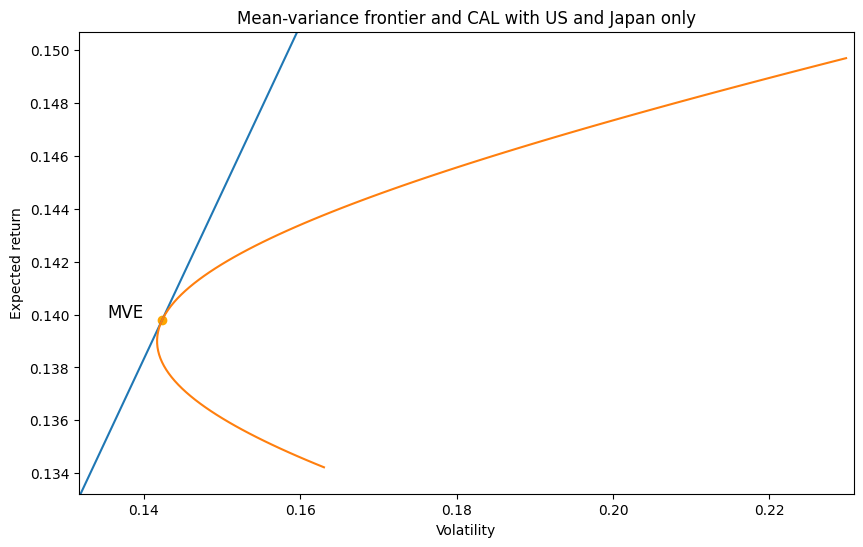

In [80]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# plot capital allocation line
ax.plot(cal_df['Deviation'], cal_df['Return'])

# plot efficient frontier
ax.plot(ef_df['Deviation'], ef_df['Return'])

# plot mearn-variance efficient portfolio
ax.scatter(mve['Deviation'], mve['Return'], color='orange')
ax.text(mve['Deviation']-0.007, mve['Return']+0.0001, 'MVE', fontsize=12)

# add title and x/y-axis labels
plt.title('Mean-variance frontier and CAL with US and Japan only')
plt.xlabel('Volatility')
plt.ylabel('Expected return')

# Set the limits of axes
plt.ylim(ef_df['Return'].min() - 0.001, ef_df['Return'].max()+0.001)
plt.xlim(ef_df['Deviation'].min() - 0.01, ef_df['Deviation'].max()+0.001)

# Show the graph
plt.show()

## Mean variance frontier of multiple assets

In [4]:
assets_df = pd.DataFrame({
  'Return': [0.1355, 0.1589, 0.1519, 0.1435, 0.1497],
  'Deviation': [0.1535, 0.2430, 0.2324, 0.2038, 0.2298]
}, index=['US', 'UK', 'France', 'Germany', 'Japan'])
asset_cor = pd.DataFrame({
  'US': [1.0000, 0.5003, 0.4398, 0.3681, 0.2663],
  'UK': [0.5003, 1.0000, 0.5420, 0.4265, 0.3581],
  'France': [0.4398, 0.5420, 1.0000, 0.6032, 0.3923],
  'Germany': [0.3681, 0.4265, 0.6032, 1.0000, 0.3663],
  'Japan': [0.2663, 0.3581, 0.3923, 0.3663, 1.0000],
}, index=['US', 'UK', 'France', 'Germany', 'Japan'])
rf_return = 0.05
asset_cov = calc_cov(assets_df['Deviation'], asset_cor.to_numpy())
asset_cov

array([[0.02356225, 0.01866144, 0.01568916, 0.01151538, 0.00939355],
       [0.01866144, 0.059049  , 0.03060847, 0.02112173, 0.01999681],
       [0.01568916, 0.03060847, 0.05400976, 0.02856943, 0.02095099],
       [0.01151538, 0.02112173, 0.02856943, 0.04153444, 0.01715502],
       [0.00939355, 0.01999681, 0.02095099, 0.01715502, 0.05280804]])

Find the mean variance efficient portfolio (MVE)

In [82]:
mve = find_mve(assets_df['Return'], asset_cov, rf_return)
mve

w1              0.507000
w2              0.075000
w3              0.025000
w4              0.189000
w5              0.204000
Return          0.142074
Deviation       0.138574
Sharpe Ratio    0.664437
dtype: float64

Find the minimum variance portfolio (GMV)

In [83]:
gmv = find_gmv(assets_df['Return'], asset_cov, rf_return)
gmv

w1              0.631000
w2             -0.013000
w3             -0.022000
w4              0.225000
w5              0.179000
Return          0.139177
Deviation       0.136372
Sharpe Ratio    0.653924
dtype: float64

Construct mean variance frontier

In [89]:
# calculate correlation of gmv and mve
gmv_mve_cor = np.dot(gmv[:-3], np.dot(mve[:-3], asset_cov))
mvf_cov = np.array([
  [gmv['Deviation']**2, gmv_mve_cor],
  [gmv_mve_cor, mve['Deviation']**2],
])

mvf = pd.DataFrame({ 'gmv_w': np.arange(-1.1, 2.2, step=0.1) })
mvf['mve_w'] = 1 - mvf['gmv_w']
weights = mvf[['gmv_w', 'mve_w']].values
mvf['Return'] = np.dot(mvf[['gmv_w', 'mve_w']], [gmv['Return'], mve['Return']])
mvf['Deviation'] = np.sqrt(np.sum(np.dot(weights, mvf_cov) * weights, axis=1))
mvf.tail()

,gmv_w,mve_w,Return,Deviation
28,1.7,-0.7,0.137149,0.137471
29,1.8,-0.8,0.136859,0.137804
30,1.9,-0.9,0.136569,0.138181
31,2.0,-1.0,0.136280,0.138601
32,2.1,-1.1,0.135990,0.139063


Plot the mean variance frontier

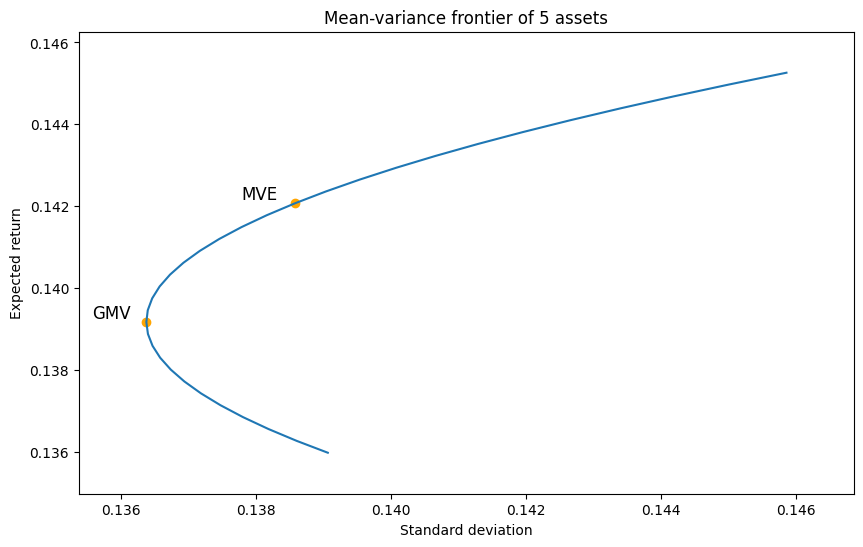

In [103]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# plot mean variance frontier
ax.plot(mvf['Deviation'], mvf['Return'])

# plot mean-variance efficient portfolio
ax.scatter(mve['Deviation'], mve['Return'], color='orange')
ax.text(mve['Deviation']-0.0008, mve['Return']+0.0001, 'MVE', fontsize=12)

# plot global minimum variance portfolio
ax.scatter(gmv['Deviation'], gmv['Return'], color='orange')
ax.text(gmv['Deviation']-0.0008, gmv['Return']+0.0001, 'GMV', fontsize=12)

# add title and x/y-axis labels
plt.title('Mean-variance frontier of 5 assets')
plt.xlabel('Standard deviation')
plt.ylabel('Expected return')

# Set the limits of axes
plt.ylim(mvf['Return'].min() - 0.001, mvf['Return'].max()+0.001)
plt.xlim(mvf['Deviation'].min() - 0.001, mvf['Deviation'].max()+0.001)

# Show the graph
plt.show()